In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import matplotlib.font_manager as fm

font_path = 'NanumGothic.ttf'
fm.fontManager.addfont(font_path)

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
df = pd.read_csv('./hotel_data_modified.csv')

## 변수별 결측치(Null) 현황 및 비율 분석

In [3]:
null_df = pd.DataFrame({'개수': df.isnull().sum(), '비율(%)': df.isnull().mean() * 100})
null_df.query('개수 > 0').sort_values('개수', ascending=False)

,개수,비율(%)
company,112593,94.306893
agent,16340,13.686238
country,488,0.408744
children,4,0.003350


## 'company' 변수의 높은 결측비율(94%)에 따른 변수 활용 가능성 및 상위기업 편중도 점검'

In [4]:
# Company 변수의 개수와 비율을 함께 확인
company_stats = pd.DataFrame({
    '개수': df['company'].value_counts().head(5),
    '비율(%)': (df['company'].value_counts(normalize=True).head(5) * 100).round(2)
})

print(company_stats)

          개수  비율(%)
company            
40.0     927  13.64
223.0    784  11.53
67.0     267   3.93
45.0     250   3.68
153.0    215   3.16


1. 대부분(94%)이 결측치이나, 상위 몇개 회사에 예약이 집중된 경향이 보임
2. 이를 통해 '개인'과 '법인'을 구분하는 파생변수로 활용하거나 특정 우량기업을 식별하는데 사용예정

## 결측치가 발견 된 변수에 대한 전처리

In [5]:
# 1. 자녀 수(Children) 빈칸 있는 행 삭제
df.dropna(subset=['children'], inplace=True)

# 2. 회사(Company), 에이전트(Agent) 빈칸은 0으로 채우기
df['company'] = df['company'].fillna(0)
df['agent'] = df['agent'].fillna(0)

# 3. 국적(Country) 빈칸은 'Unknown'로 채우기
df['country'] = df['country'].fillna('Unknown')

# 확인
print("남은 결측치 개수:", df.isnull().sum().sum())
print("Unknown 수:", (df['country']=='Unknown').sum())

남은 결측치 개수: 0
Unknown 수: 488


1. Children(자녀수)
    - 전체 데이터 중 단 4건(극소수)이므로, 데이터 분포에 영향이 적다고 판단하여 제거(Drop)

2. Company&Agent(회사&대행사)
    - 결측치는 누락된 것이 아니라, 에이전트나 회사를 통하지 않은 직접예약으로 해석
    - 따라서 삭제하지 않고 0이라는 범주형 값으로 대체하여 정보를 보존함

3. Country(국적)
    - 특정 국가로 임의 가정할 경우 편향이 생길 수 있음
    - 데이터의 객관성을 유지하기 위해 Unknown이라는 별도 범주로 분류하여 분석 진행

## 결측치 여부 시각화

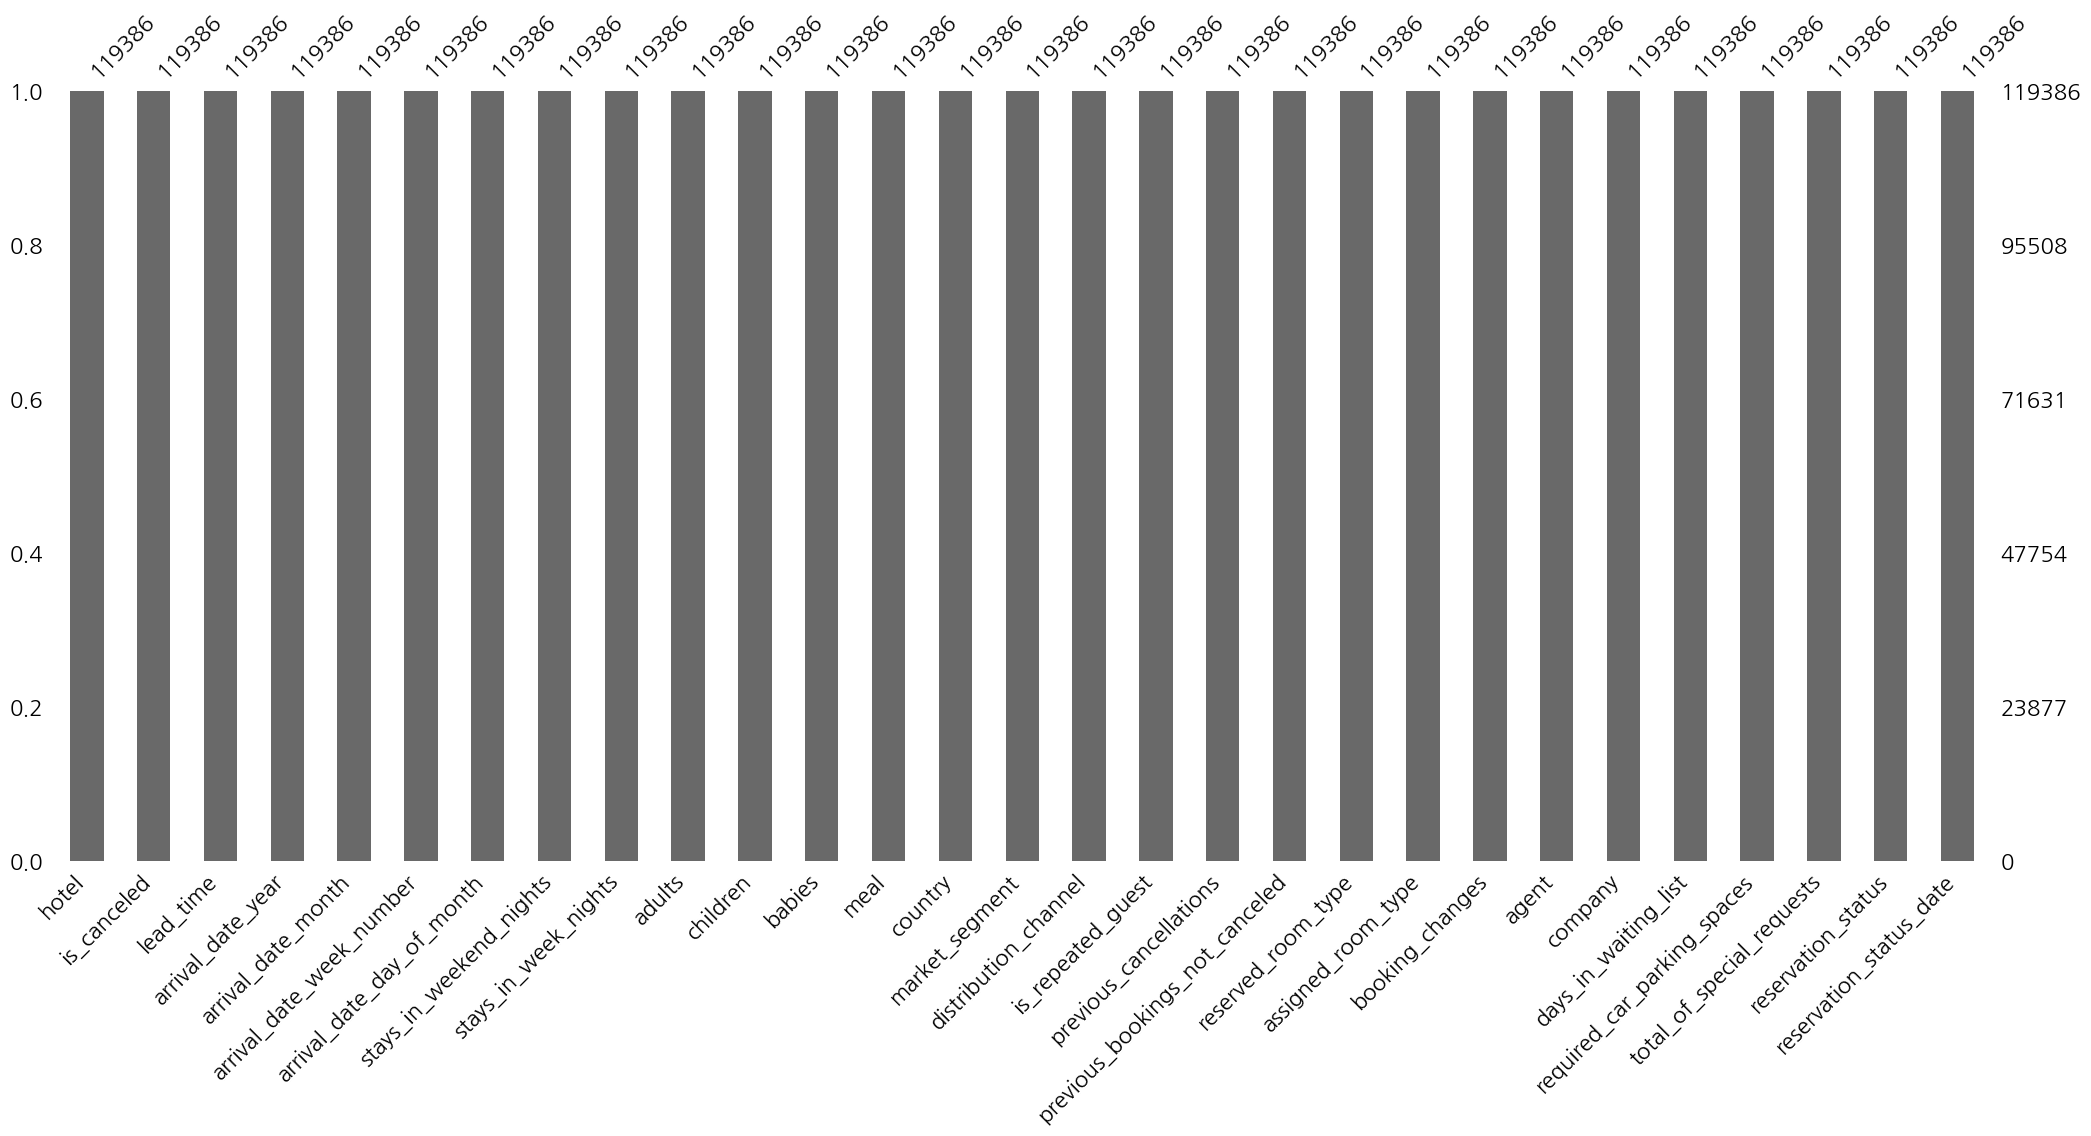

In [6]:
msno.bar(df)
plt.show()

# 주요 변수별 데이터 비중(%) 분석

In [7]:
# 비중(%)만 계산하여 데이터프레임을 만드는 함수
def get_top_pct_only(df, column, name_label, pct_label, top_n=5):
    pcts = (df[column].value_counts(normalize=True).head(top_n) * 100).round(2)
    return pd.DataFrame({
        name_label: pcts.index,
        pct_label: pcts.values
    }).reset_index(drop=True)

# 각 컬럼별 비중 통계 생성
country_pct_stats = get_top_pct_only(df, 'country', 'Country', 'Pct_C(%)')
agent_pct_stats = get_top_pct_only(df, 'agent', 'Agent', 'Pct_A(%)')
company_pct_stats = get_top_pct_only(df, 'company', 'Company', 'Pct_Cp(%)')

# 가로로 합치기
combined_pct_stats = pd.concat([country_pct_stats, agent_pct_stats, company_pct_stats], axis=1)

print(combined_pct_stats)

  Country  Pct_C(%)  Agent  Pct_A(%)  Company  Pct_Cp(%)
0     PRT     40.70    9.0     26.77      0.0      94.31
1     GBR     10.16    0.0     13.69     40.0       0.78
2     FRA      8.72  240.0     11.66    223.0       0.66
3     ESP      7.18    1.0      6.02     67.0       0.22
4     DEU      6.10   14.0      3.05     45.0       0.21


### 데이터의 쏠림 현상을 파악하기 위해 주요 컬럼의 TOP 5 비중을 산출합니다.
1. Country
    - 포르투갈(PRT)이 약 40%로 압도적이며
    - PRT와 GBR을 제외한 나머지 국가는 Others로 변경 예정

2. Agent
    - 특정 에이전트와 직접 예약(0.0)에 데이터가 집중되어 있으며
    - 상위3개의 데이터 외에는 999로 묶을 예정

3. Company
    - 개인 고객(0.0) 비중이 94% 이상으로
    - 법인 데이터의 희소성을 확인하였으며 법인을 1로 묶을 예정

## 데이터 통합 및 범주 최적화

In [8]:
# 0. 특정 컬럼에서 keep_list에 포함되지 않은 값들은 전부 default_value로 덮어쓰기
def map_categories(df, column, keep_list, default_value):
    df[column] = df[column].apply(lambda x: x if x in keep_list else default_value)
    return df

# 1. 시계열 분석을 위한 날짜 통합 (YYYY-MM-DD)
df['arrival_date'] = pd.to_datetime(
    df['arrival_date_year'].astype(str) + '-' + 
    df['arrival_date_month'].astype(str) + '-' + 
    df['arrival_date_day_of_month'].astype(str)
)

# 2. 통합 후 불필요해진 개별 날짜 컬럼 제거
cols_to_drop = ['arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'arrival_date_month']
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# 3. ID형 변수의 데이터 타입을 문자열로 통일
df['agent'] = df['agent'].astype(int).astype(str)
df['company'] = df['company'].astype(int).astype(str)

# 4. 주요 범주 외 데이터 그룹화 실행 (Others/999/1 처리)
map_categories(df, 'country', ['PRT', 'GBR'], 'Others')
map_categories(df, 'agent', ['9', '0', '240'], '999') # 주요 에이전트 외 통합
map_categories(df, 'company', ['0'], '1')            # 개인(0) vs 법인(1) 이진화

# 5. 전처리 결과 검증을 위한 상위 비중 재산출
new_country_stats = get_top_pct_only(df, 'country', 'Country', 'Pct_C(%)')
new_agent_stats = get_top_pct_only(df, 'agent', 'Agent', 'Pct_A(%)')
new_company_stats = get_top_pct_only(df, 'company', 'Company', 'Pct_Cp(%)')

# 컬럼별 통계 가로 결합 및 확인
combined_after_stats = pd.concat([new_country_stats, new_agent_stats, new_company_stats], axis=1)
print(combined_after_stats)

  Country  Pct_C(%) Agent  Pct_A(%) Company  Pct_Cp(%)
0  Others     49.14   999     47.88       0      94.31
1     PRT     40.70     9     26.77       1       5.69
2     GBR     10.16     0     13.69     NaN        NaN
3     NaN       NaN   240     11.66     NaN        NaN


1. 시계열 데이터 통합 및 효율화
    - 날짜 통합
        - 분산되어 있던 연(year), 월(month), 일(day) 정보를 하나의 arrival_date 변수로 병합하고 datetime 타입으로 변환하였습니다. 이를 통해 향후 요일별 분석이나 월별 트렌드 파악 등 시계열 분석이 가능해졌습니다.

    - 불필요 변수 제거
        - 모델링 및 분석 시 복잡도를 높이고 영향력이 낮은 상세 날짜 변수(year, week, day)를 삭제하여 데이터의 차원을 축소하고 효율성을 높였습니다.


2. 데이터 타입 통일 및 정제
    - 식별자 변수 변환
        - 수치형(float/int)으로 되어 있으나 실제로는 예약 주체를 구분하는 ID 역할을 하는 agent와 company 변수를 정수형을 거쳐 문자열(str)로 환하였습니다. 이는 분석기(모델)가 해당 숫자를 크기(Scale)로 오해하지 않도록 방지하고 데이터의 일관성을 확보하기 위함입니다.


3. 전략적 데이터 범주 단순화 (Binning)
    - Country(국적)
        - 비중이 높은 상위 국가(PRT, GBR) 외의 수많은 국가는 분석의 집중도를 위해 모두 Others로 통합하였습니다.

    - Agent(예약 대행사)
        - 예약 비중이 가장 높은 주요 대행사 3곳 외에는 기타 카테고리인 999로 그룹화하여 변수의 변동성을 제어했습니다.

    - Company(예약 회사)
        - 결측치가 많았던 회사 정보를 활용하여, 예약 주체가 **개인(0)**인지 **법인(1)**인지에 집중한 이진화(Binary) 처리를 수행했습니다.

In [9]:
df['hotel'].value_counts()

hotel
City Hotel      79326
Resort Hotel    40060
Name: count, dtype: int64

In [10]:
target_hotel = 'City Hotel'
df_target = df[df['hotel'] == target_hotel].copy()
print(f"[{target_hotel}] 데이터 개수: {len(df_target)}개")

[City Hotel] 데이터 개수: 79326개


[City Hotel] 데이터 개수: 79326개


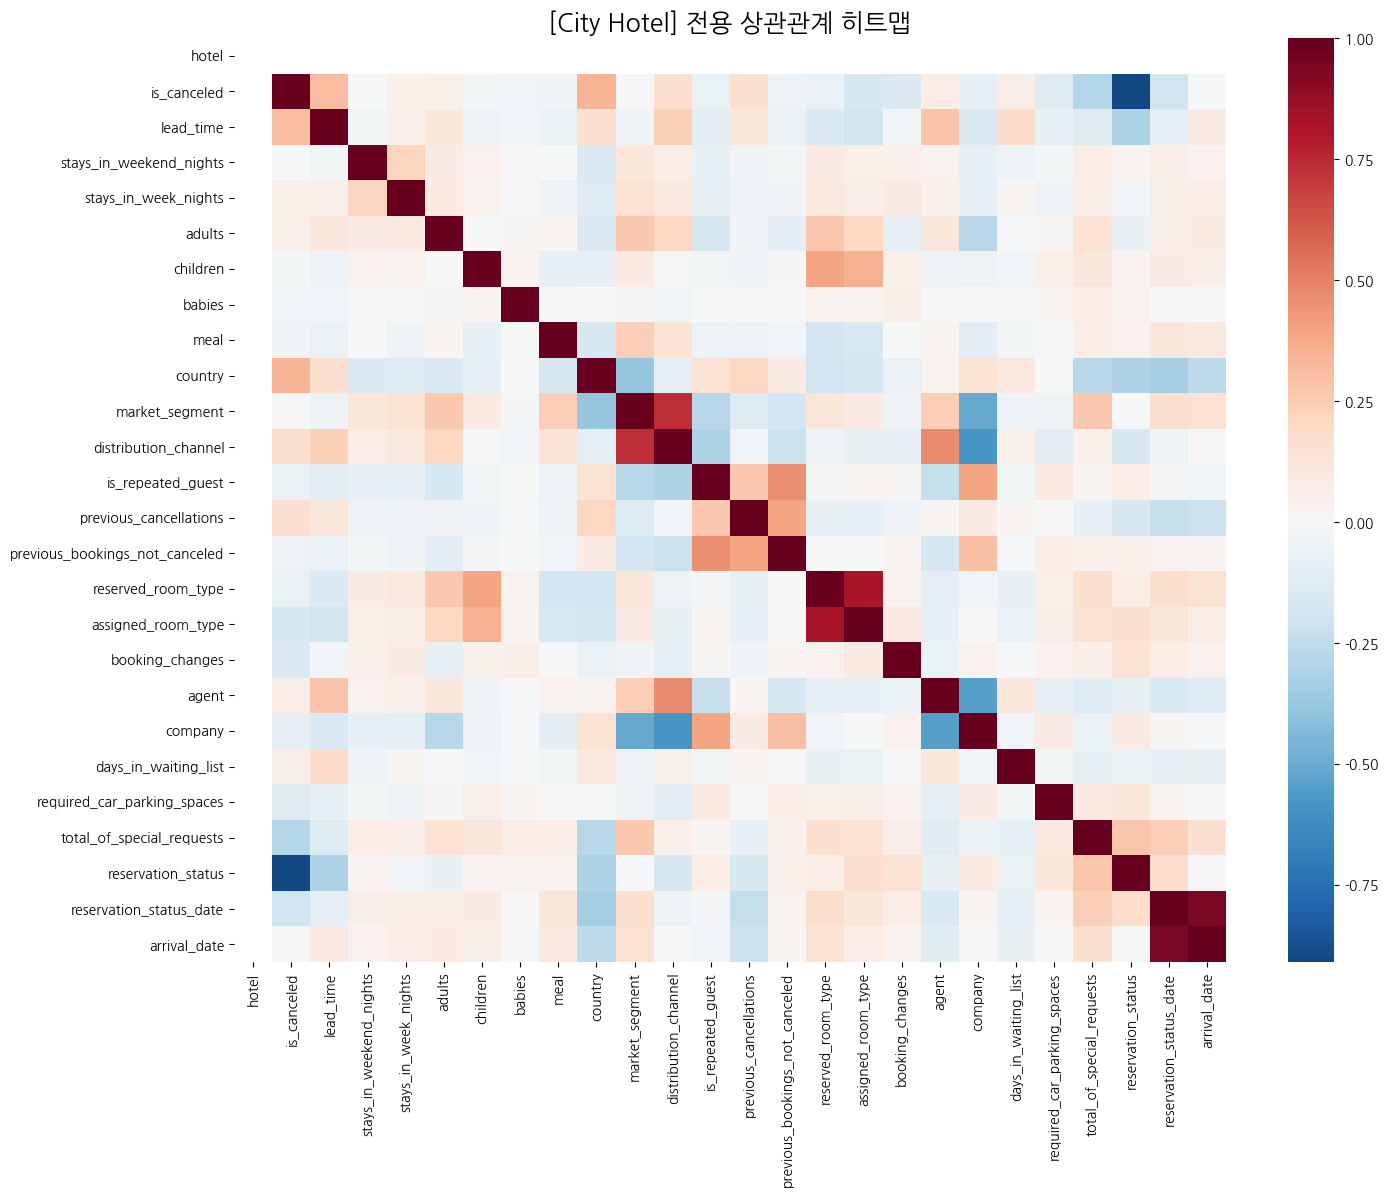

--- [City Hotel] 취소 여부와의 상관관계 TOP 10 ---
is_canceled                  1.000000
reservation_status           0.910226
country                      0.336452
lead_time                    0.309317
total_of_special_requests    0.293961
reservation_status_date      0.194695
previous_cancellations       0.166660
distribution_channel         0.164471
assigned_room_type           0.164321
booking_changes              0.149487
Name: is_canceled, dtype: float64


In [15]:
target_hotel = 'City Hotel'
df_target = df[df['hotel'] == target_hotel].copy()
print(f"[{target_hotel}] 데이터 개수: {len(df_target)}개")
# ==========================================

# 2. 문자열 모조리 숫자로 변환 (철벽 방어)
non_numeric_cols = df_target.select_dtypes(exclude=['number']).columns

for col in non_numeric_cols:
    df_target[col] = df_target[col].astype('str').astype('category').cat.codes

# 3. 상관관계 계산
corr_matrix_target = df_target.corr()

# 4. 히트맵 그리기
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix_target, annot=False, cmap='RdBu_r', center=0)
plt.title(f'[{target_hotel}] 전용 상관관계 히트맵', fontsize=18, fontweight='bold')
plt.show()

# 5. 해당 호텔의 취소(is_canceled)와 가장 상관관계가 높은 TOP 10
print(f"--- [{target_hotel}] 취소 여부와의 상관관계 TOP 10 ---")
print(corr_matrix_target['is_canceled'].abs().sort_values(ascending=False).head(10))

In [20]:
target_hotel = 'Resort Hotel'
df_target = df[df['hotel'] == target_hotel].copy()

corr_matrix = df_target.corr(numeric_only=True)
print(corr_matrix['is_canceled'].abs().sort_values(ascending=False).head(10))

is_canceled                    1.000000
required_car_parking_spaces    0.243863
lead_time                      0.229444
booking_changes                0.114835
previous_cancellations         0.114173
is_repeated_guest              0.103563
total_of_special_requests      0.101295
children                       0.081234
adults                         0.080546
stays_in_weekend_nights        0.078569
Name: is_canceled, dtype: float64


In [21]:
target_hotel = 'City Hotel'
df_target = df[df['hotel'] == target_hotel].copy()

corr_matrix = df_target.corr(numeric_only=True)
print(corr_matrix['is_canceled'].abs().sort_values(ascending=False).head(10))

is_canceled                       1.000000
lead_time                         0.309317
total_of_special_requests         0.293961
previous_cancellations            0.166660
booking_changes                   0.149487
required_car_parking_spaces       0.133092
is_repeated_guest                 0.065833
days_in_waiting_list              0.060976
previous_bookings_not_canceled    0.053131
adults                            0.053011
Name: is_canceled, dtype: float64


In [25]:
target_hotel = 'Resort Hotel'
df_target = df[df['hotel'] == target_hotel].copy()
print(f"[{target_hotel}] 데이터 개수: {len(df_target)}개")
# ==========================================

# 2. 문자열 모조리 숫자로 변환 (철벽 방어)
non_numeric_cols = df_target.select_dtypes(exclude=['number']).columns

for col in non_numeric_cols:
    df_target[col] = df_target[col].astype('str').astype('category').cat.codes

# 3. 상관관계 계산
corr_matrix_target = df_target.corr()


# 5. 해당 호텔의 취소(is_canceled)와 가장 상관관계가 높은 TOP 10
print(f"--- [{target_hotel}] 취소 여부와의 상관관계 TOP 10 ---")
print(corr_matrix_target['is_canceled'].abs().sort_values(ascending=False).head(7))

[Resort Hotel] 데이터 개수: 40060개
--- [Resort Hotel] 취소 여부와의 상관관계 TOP 10 ---
is_canceled                    1.000000
reservation_status             0.929639
country                        0.269512
required_car_parking_spaces    0.243863
lead_time                      0.229444
market_segment                 0.137287
distribution_channel           0.115290
Name: is_canceled, dtype: float64


In [27]:
target_hotel = 'City Hotel'
df_target = df[df['hotel'] == target_hotel].copy()
print(f"[{target_hotel}] 데이터 개수: {len(df_target)}개")
# ==========================================

# 2. 문자열 모조리 숫자로 변환 (철벽 방어)
non_numeric_cols = df_target.select_dtypes(exclude=['number']).columns

for col in non_numeric_cols:
    df_target[col] = df_target[col].astype('str').astype('category').cat.codes

# 3. 상관관계 계산
corr_matrix_target = df_target.corr()


# 5. 해당 호텔의 취소(is_canceled)와 가장 상관관계가 높은 TOP 10
print(f"--- [{target_hotel}] 취소 여부와의 상관관계 TOP 10 ---")
print(corr_matrix_target['is_canceled'].abs().sort_values(ascending=False).head(7))

[City Hotel] 데이터 개수: 79326개
--- [City Hotel] 취소 여부와의 상관관계 TOP 10 ---
is_canceled                  1.000000
reservation_status           0.910226
country                      0.336452
lead_time                    0.309317
total_of_special_requests    0.293961
reservation_status_date      0.194695
previous_cancellations       0.166660
Name: is_canceled, dtype: float64


C:\Users\gogiz\AppData\Local\Temp\ipykernel_10068\4028254126.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='market_segment', y='is_canceled', palette='Set2')


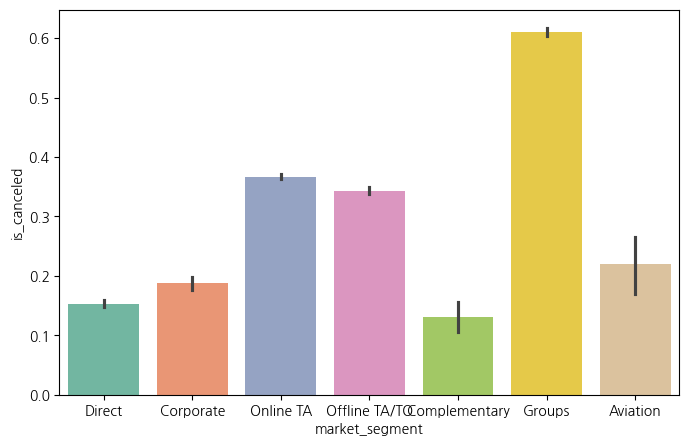

In [31]:
plt.figure(figsize=(8, 5))

# 막대그래프: 각 국가 그룹(PRT, GBR, Others)의 평균 취소율을 보여줍니다.
sns.barplot(data=df, x='market_segment', y='is_canceled', palette='Set2')

# plt.title('국가 그룹별 취소율 비교 (귀한님의 전처리 결과)', fontsize=16, fontweight='bold')
# plt.xlabel('국가 그룹', fontsize=12)
# plt.ylabel('평균 취소율 (1.0 = 100% 취소)', fontsize=12)

plt.show()

C:\Users\gogiz\AppData\Local\Temp\ipykernel_10068\685197635.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='distribution_channel', y='is_canceled', palette='Set2')


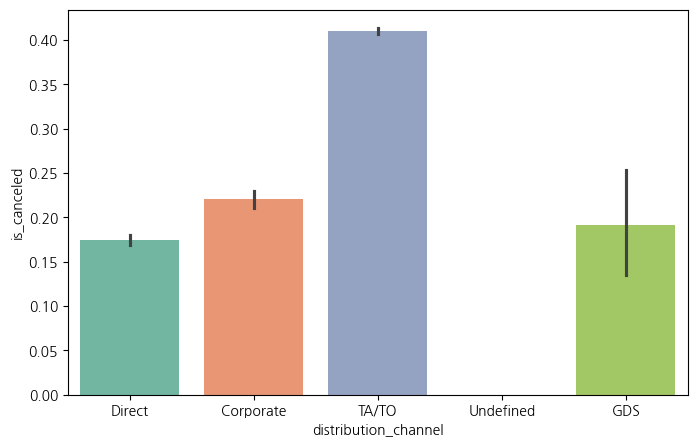

In [32]:
plt.figure(figsize=(8, 5))

# 막대그래프: 각 국가 그룹(PRT, GBR, Others)의 평균 취소율을 보여줍니다.
sns.barplot(data=df, x='distribution_channel', y='is_canceled', palette='Set2')

# plt.title('국가 그룹별 취소율 비교 (귀한님의 전처리 결과)', fontsize=16, fontweight='bold')
# plt.xlabel('국가 그룹', fontsize=12)
# plt.ylabel('평균 취소율 (1.0 = 100% 취소)', fontsize=12)

plt.show()

In [36]:
# market_segment별 '데이터 개수(count)'와 '평균 취소율(mean)'을 구해서 표로 출력
segment_table = df.groupby('market_segment')['is_canceled'].agg(['count', 'mean'])

# 취소율(mean)이 높은 순서대로 정렬
segment_table = segment_table.sort_values(by='mean', ascending=False)

# 취소율을 보기 쉽게 %로 변환해서 한 번 더 출력
segment_table['취소율(%)'] = (segment_table['mean'] * 100).round(1)

print("--- [Market Segment별 취소율 표] ---")
print(segment_table[['count', '취소율(%)']])

--- [Market Segment별 취소율 표] ---
                count  취소율(%)
market_segment               
Groups          19811    61.1
Online TA       56476    36.7
Offline TA/TO   24219    34.3
Aviation          237    21.9
Corporate        5295    18.7
Direct          12605    15.3
Complementary     743    13.1


C:\Users\gogiz\AppData\Local\Temp\ipykernel_10068\241168177.py:28: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  for col in df_ml.select_dtypes(include=['object', 'category']).columns:
C:\Users\gogiz\AppData\Local\Temp\ipykernel_10068\241168177.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(15), x='Importance', y='Feature', palette='viridis')


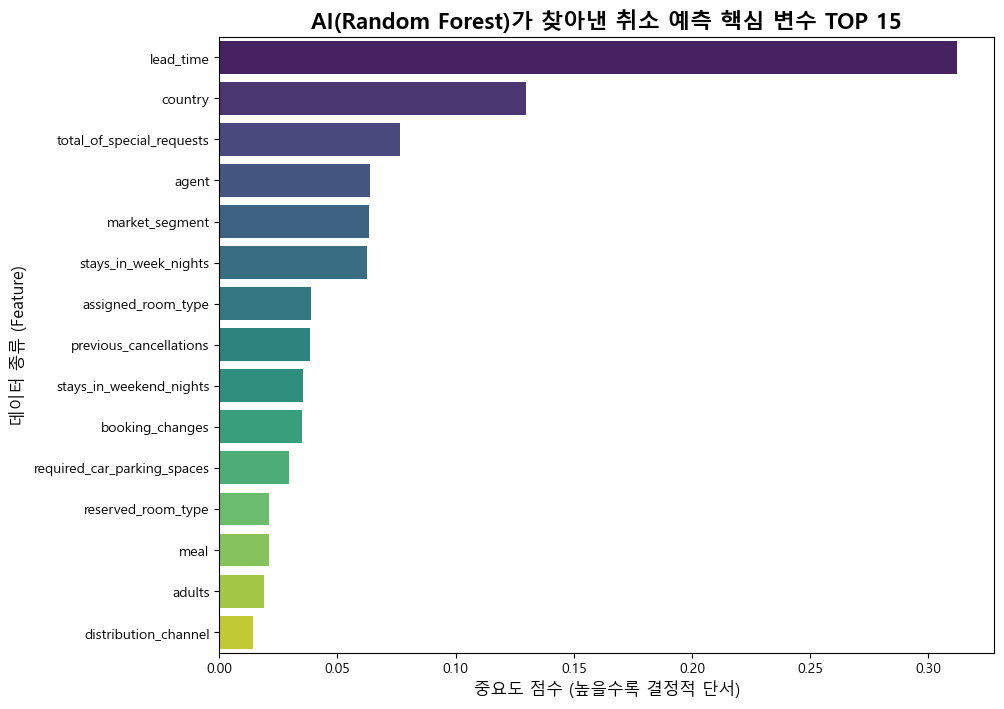

--- [텍스트로 보는 TOP 10] ---
                  Feature  Importance
                lead_time    0.312249
                  country    0.129584
total_of_special_requests    0.076286
                    agent    0.063553
           market_segment    0.063459
     stays_in_week_nights    0.062289
       assigned_room_type    0.038604
   previous_cancellations    0.038557
  stays_in_weekend_nights    0.035317
          booking_changes    0.035110


In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# 1. 한글 설정 (VS Code용)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 2. 데이터 준비 (원본 보호를 위해 복사)
df_ml = df.copy()

# 결측치(NaN)가 있으면 AI가 공부를 못 하므로 간단히 0이나 'Unknown'으로 채웁니다.
for col in df_ml.columns:
    if df_ml[col].dtype == 'object':
        df_ml[col] = df_ml[col].fillna('Unknown')
    else:
        df_ml[col] = df_ml[col].fillna(0)

# 3. 🚨 스파이(Data Leakage) 제거!
# 예약 상태(이미 취소됐는지 알려주는 결과값)는 시험지에서 빼야 합니다.
cols_to_drop = ['reservation_status', 'reservation_status_date']
df_ml = df_ml.drop(columns=[col for col in cols_to_drop if col in df_ml.columns])

# 4. 글자 데이터를 숫자로 변환 (Label Encoding)
le = LabelEncoder()
for col in df_ml.select_dtypes(include=['object', 'category']).columns:
    df_ml[col] = le.fit_transform(df_ml[col].astype(str))

# 5. 문제(X)와 정답(y) 나누기
X = df_ml.drop(columns=['is_canceled']) # 원인들
y = df_ml['is_canceled']                # 결과 (취소 여부)

# 🚨 추가된 철벽 방어: 날짜(datetime) 등 숫자가 아닌 데이터는 AI가 읽지 못하므로 뺍니다.
X = X.select_dtypes(include=['number'])

# 6. AI 모델 불러오기 및 학습 (Random Forest)
# 12만 개라 시간이 걸릴 수 있어서 나무(n_estimators)는 50개만 심겠습니다.
rf_model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
rf_model.fit(X, y)

# 7. AI가 매긴 중요도(Feature Importance) 뽑아내기
importances = rf_model.feature_importances_
feature_names = X.columns

# 표로 예쁘게 만들기
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 8. 상위 15개 시각화
plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('AI(Random Forest)가 찾아낸 취소 예측 핵심 변수 TOP 15', fontsize=16, fontweight='bold')
plt.xlabel('중요도 점수 (높을수록 결정적 단서)', fontsize=12)
plt.ylabel('데이터 종류 (Feature)', fontsize=12)
plt.show()

print("--- [텍스트로 보는 TOP 10] ---")
print(importance_df.head(10).to_string(index=False))

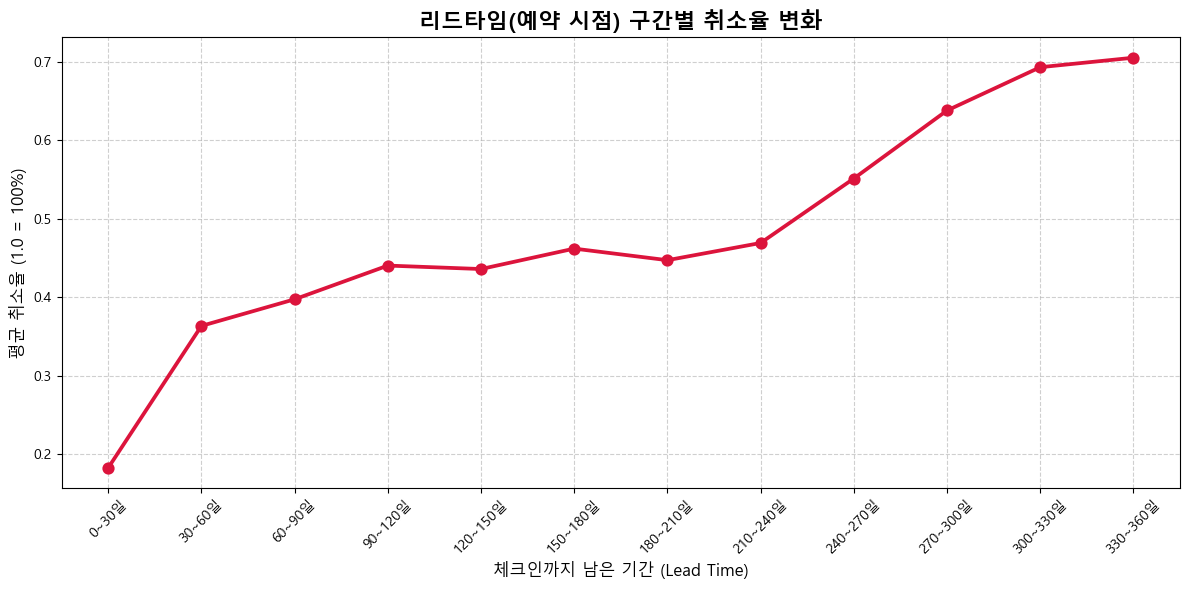

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. 한글 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 2. 리드타임(lead_time)을 한 달(30일) 단위로 묶어서 그룹화하기
# 예: 0~30일, 30~60일 ... 최대 360일(약 1년)까지만 봅니다.
bins = np.arange(0, 390, 30) 
labels = [f'{i}~{i+30}일' for i in range(0, 360, 30)]
df['lead_time_group'] = pd.cut(df['lead_time'], bins=bins, labels=labels, right=False)

# 3. 구간별 평균 취소율 계산
lead_time_cancel_rate = df.groupby('lead_time_group')['is_canceled'].mean().reset_index()

# 4. 시각화 (선 그래프)
plt.figure(figsize=(12, 6))
sns.pointplot(data=lead_time_cancel_rate, x='lead_time_group', y='is_canceled', color='crimson', markers='o')

# 꾸미기
plt.title('리드타임(예약 시점) 구간별 취소율 변화', fontsize=16, fontweight='bold')
plt.xlabel('체크인까지 남은 기간 (Lead Time)', fontsize=12)
plt.ylabel('평균 취소율 (1.0 = 100%)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()